<a href="https://colab.research.google.com/github/valmadrid/Detecting-Financial-Fraud-Transactions/blob/master/financial_fraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf 
tf.test.gpu_device_name() 

'/device:GPU:0'

In [19]:
# import warnings
# warnings.filterwarnings("ignore")

import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", -1)

import numpy as np

import pandas_profiling

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("white")
sns.set_context("paper", font_scale=1.8)
sns.set_palette("GnBu_d")

import pickle

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


***step*** - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

***type*** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

***amount*** - amount of the transaction in local currency (assume $).

***nameOrig*** - customer who started the transaction

***oldbalanceOrg*** - initial balance before the transaction

***newbalanceOrig*** - new balance after the transaction

***nameDest*** - customer who is the recipient of the transaction

***oldbalanceDest*** - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

***newbalanceDest*** - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

***isFraud*** - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

***isFlaggedFraud*** - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than $200,000 in a single transaction.

In [0]:
from google.colab import auth
auth.authenticate_user()

from pydrive.drive import GoogleDrive
from pydrive.auth import GoogleAuth
from oauth2client.client import GoogleCredentials
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
myfile = drive.CreateFile({"id": "1qW2WhTNFtrZY5GVLsZRjl5O2xD1ws7Hn"})
myfile.GetContentFile("file.csv")

In [0]:
df = pd.read_csv("file.csv") 

In [0]:
pickle.dump(df, open("file.pkl", "wb"))

In [6]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [22]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   step                   6362620 non-null  int64  
 1   type                   6362620 non-null  object 
 2   amount                 6362620 non-null  float64
 3   customer               6362620 non-null  object 
 4   customer_old_balance   6362620 non-null  float64
 5   customer_new_balance   6362620 non-null  float64
 6   recipient              6362620 non-null  object 
 7   recipient_old_balance  6362620 non-null  float64
 8   recipient_new_balance  6362620 non-null  float64
 9   is_fraud               6362620 non-null  int64  
 10  is_flagged_fraud       6362620 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [0]:
# Rename column headers to indicate months
df.rename(mapper={
    "nameOrig": "customer",
    "oldbalanceOrg": "customer_old_balance",
    "newbalanceOrig": "customer_new_balance",
    "nameDest": "recipient",
    "oldbalanceDest": "recipient_old_balance",
    "newbalanceDest": "recipient_new_balance",
    "isFraud": "is_fraud",
    "isFlaggedFraud": "is_flagged_fraud"
},
          axis=1,
          inplace=True)

In [10]:
# Descriptive statistics
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
step,6.36262e+06,NaN,NaN,NaN,243.397,142.332,1,156,239,335,743
type,6362620,5,CASH_OUT,2237500,NaN,NaN,NaN,NaN,NaN,NaN,NaN
amount,6.36262e+06,NaN,NaN,NaN,179862,603858,0,13389.6,74871.9,208721,9.24455e+07
customer,6362620,6353307,C1902386530,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
customer_old_balance,6.36262e+06,NaN,NaN,NaN,833883,2.88824e+06,0,0,14208,107315,5.9585e+07
customer_new_balance,6.36262e+06,NaN,NaN,NaN,855114,2.92405e+06,0,0,0,144258,4.9585e+07
recipient,6362620,2722362,C1286084959,113,NaN,NaN,NaN,NaN,NaN,NaN,NaN
recipient_old_balance,6.36262e+06,NaN,NaN,NaN,1.1007e+06,3.39918e+06,0,0,132706,943037,3.56016e+08
recipient_new_balance,6.36262e+06,NaN,NaN,NaN,1.225e+06,3.67413e+06,0,0,214661,1.11191e+06,3.56179e+08
is_fraud,6.36262e+06,NaN,NaN,NaN,0.00129082,0.0359048,0,0,0,0,1


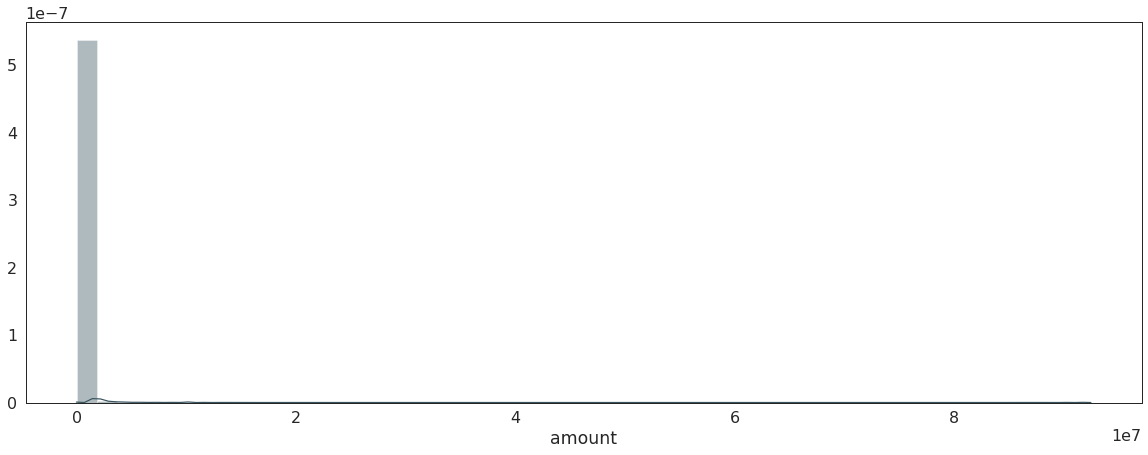

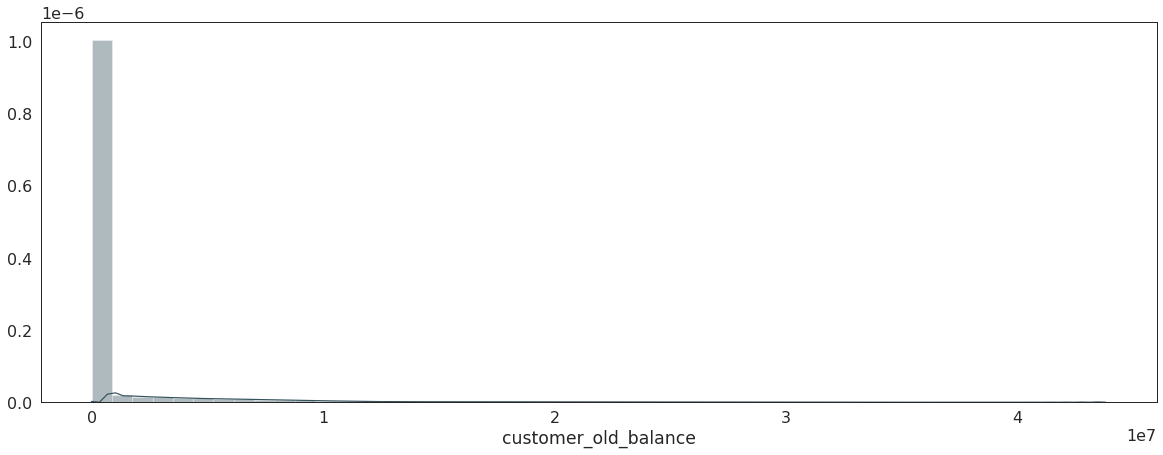

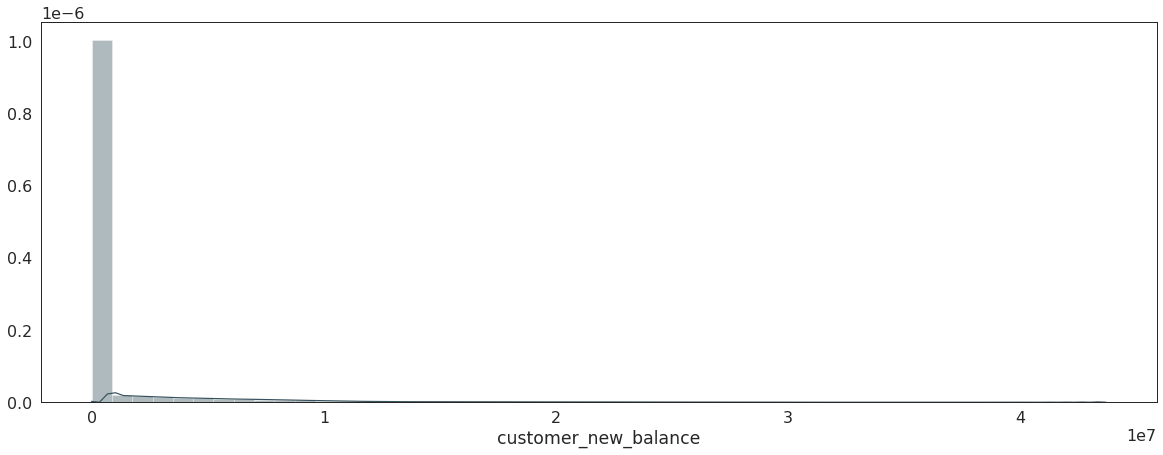

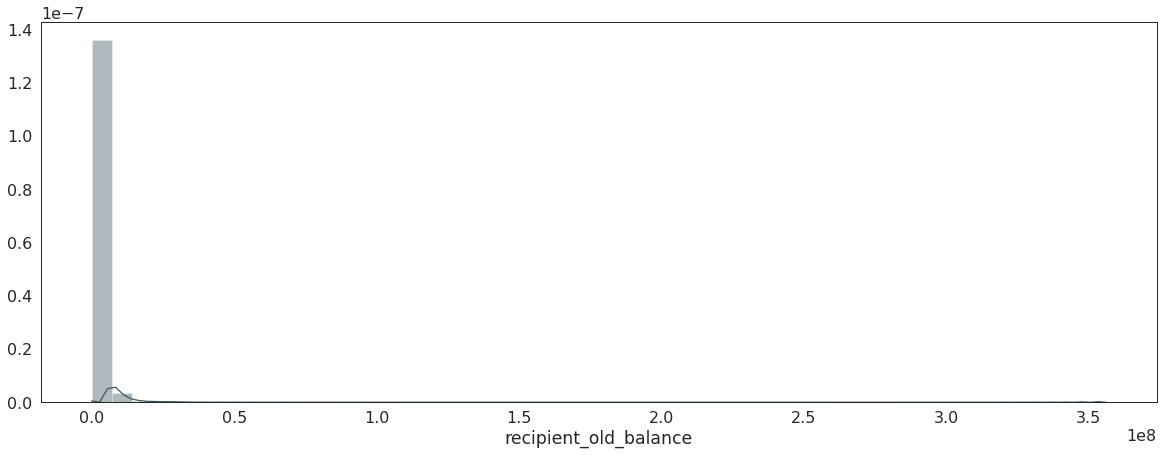

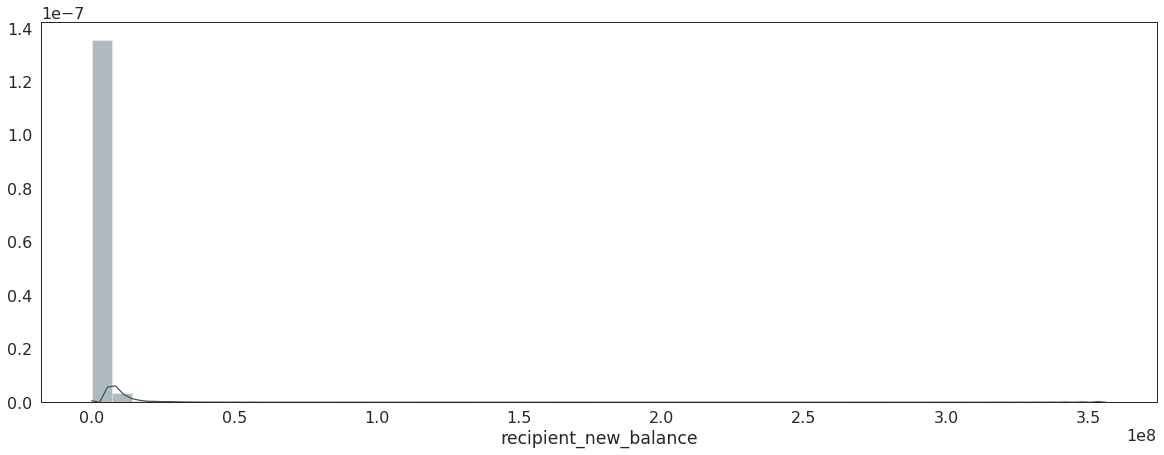

In [23]:
cols = [
    "amount", "customer_old_balance", "customer_new_balance",
    "recipient_old_balance", "recipient_new_balance"
]
for col in cols:
    plt.figure(figsize=(20, 7))
    sns.distplot(df.query("is_fraud == 0")[col])
    plt.show()

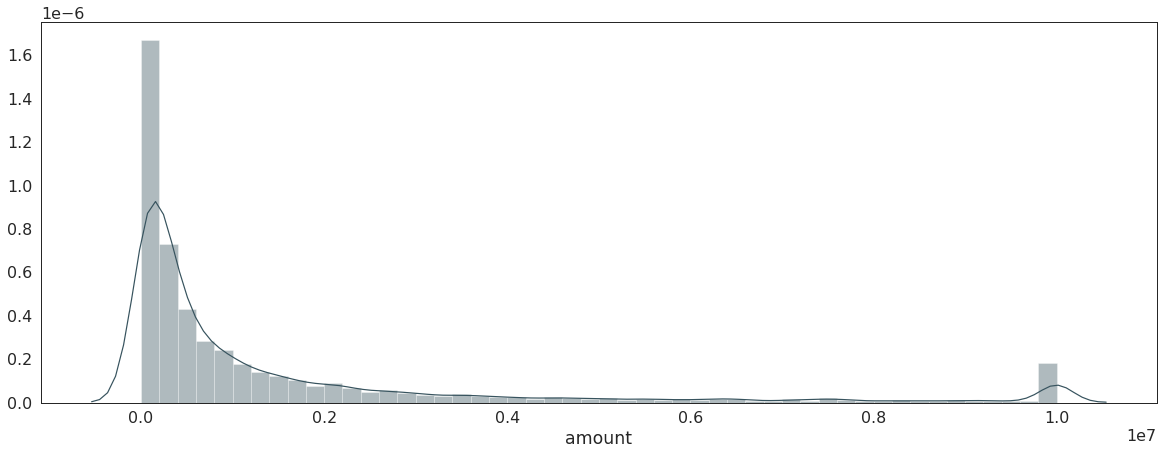

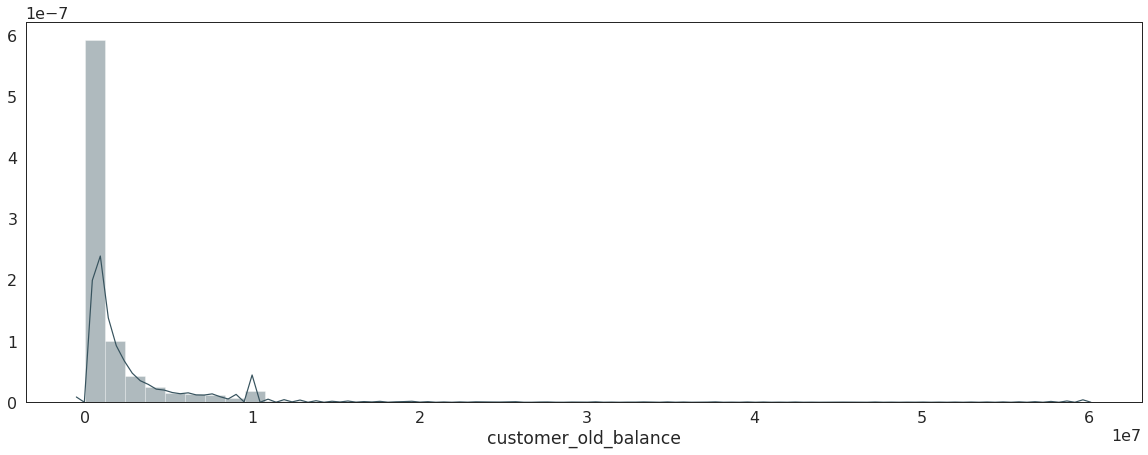

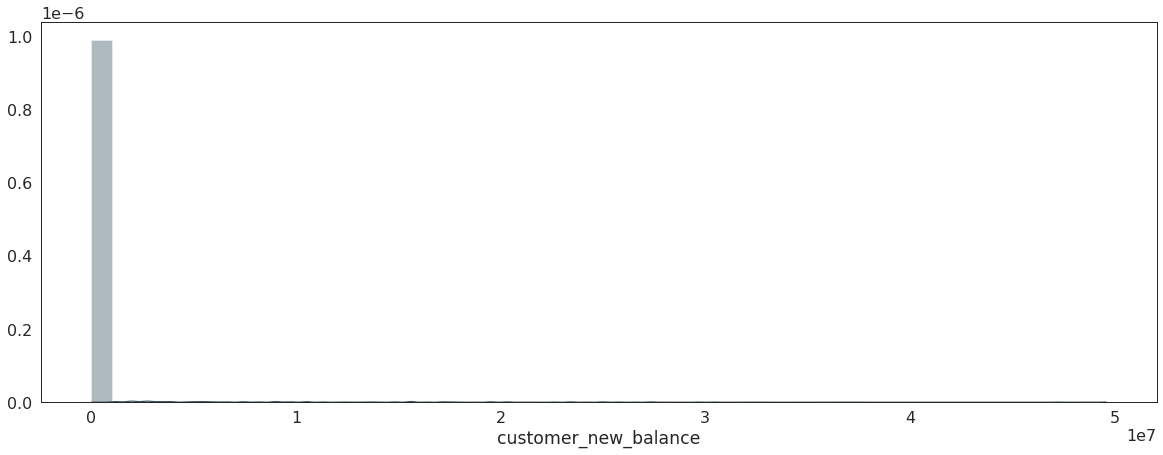

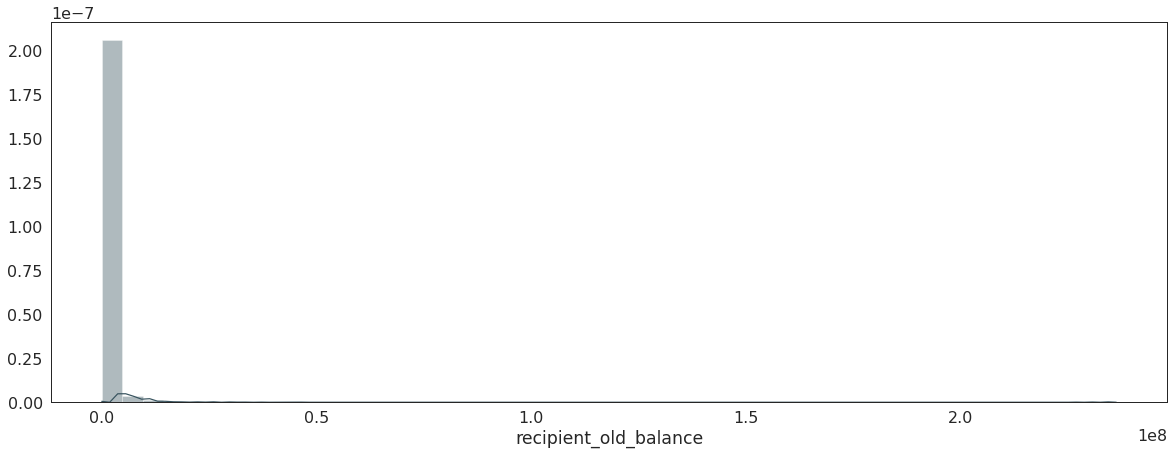

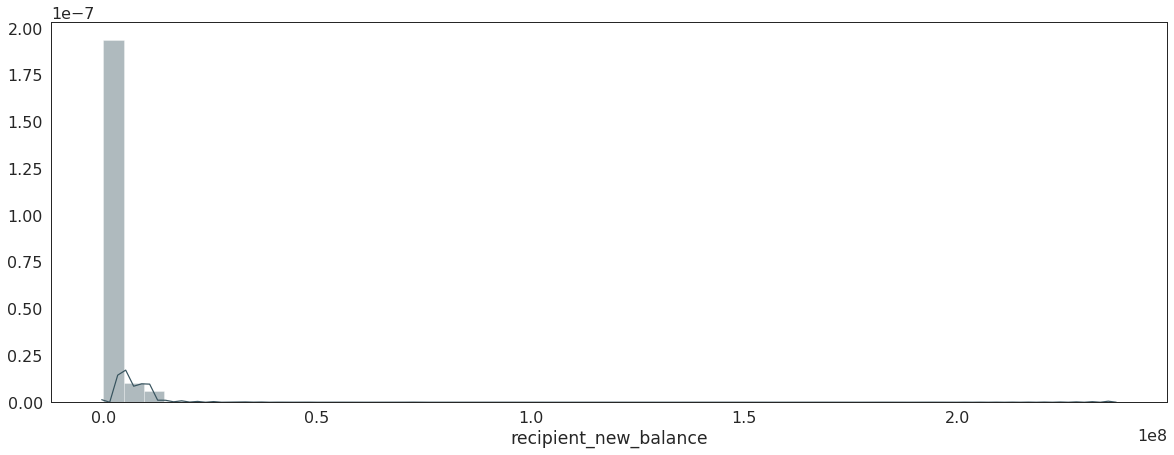

In [24]:
for col in cols:
    plt.figure(figsize=(20, 7))
    sns.distplot(df.query("is_fraud == 1")[col])
    plt.show()

In [25]:
cols = ["type", "is_fraud", "is_flagged_fraud"]

for col in cols:
    print("FEATURE: ", col)
    print(df[col].value_counts(normalize=True)*100)

FEATURE:  type
CASH_OUT    35.166331
PAYMENT     33.814608
CASH_IN     21.992261
TRANSFER    8.375622 
DEBIT       0.651178 
Name: type, dtype: float64
FEATURE:  is_fraud
0    99.870918
1    0.129082 
Name: is_fraud, dtype: float64
FEATURE:  is_flagged_fraud
0    99.999749
1    0.000251 
Name: is_flagged_fraud, dtype: float64


In [26]:
cols = ["type", "is_flagged_fraud"]

for col in cols:
    print("FEATURE: ", col)
    print(df.query("is_fraud == 0")[col].value_counts(normalize=True)*100)

FEATURE:  type
CASH_OUT    35.147009
PAYMENT     33.858313
CASH_IN     22.020686
TRANSFER    8.321972 
DEBIT       0.652020 
Name: type, dtype: float64
FEATURE:  is_flagged_fraud
0    100.0
Name: is_flagged_fraud, dtype: float64


In [27]:
for col in cols:
    print("FEATURE: ", col)
    print(df.query("is_fraud == 1")[col].value_counts(normalize=True)*100)

FEATURE:  type
CASH_OUT    50.11567
TRANSFER    49.88433
Name: type, dtype: float64
FEATURE:  is_flagged_fraud
0    99.805187
1    0.194813 
Name: is_flagged_fraud, dtype: float64


In [28]:
cols = ["type", "is_fraud"]

for col in cols:
    print("FEATURE: ", col)
    print(df.query("is_flagged_fraud == 0")[col].value_counts(normalize=True)*100)

FEATURE:  type
CASH_OUT    35.166419
PAYMENT     33.814693
CASH_IN     21.992316
TRANSFER    8.375392 
DEBIT       0.651180 
Name: type, dtype: float64
FEATURE:  is_fraud
0    99.871169
1    0.128831 
Name: is_fraud, dtype: float64


In [29]:
for col in cols:
    print("FEATURE: ", col)
    print(df.query("is_flagged_fraud == 1")[col].value_counts(normalize=True)*100)

FEATURE:  type
TRANSFER    100.0
Name: type, dtype: float64
FEATURE:  is_fraud
1    100.0
Name: is_fraud, dtype: float64


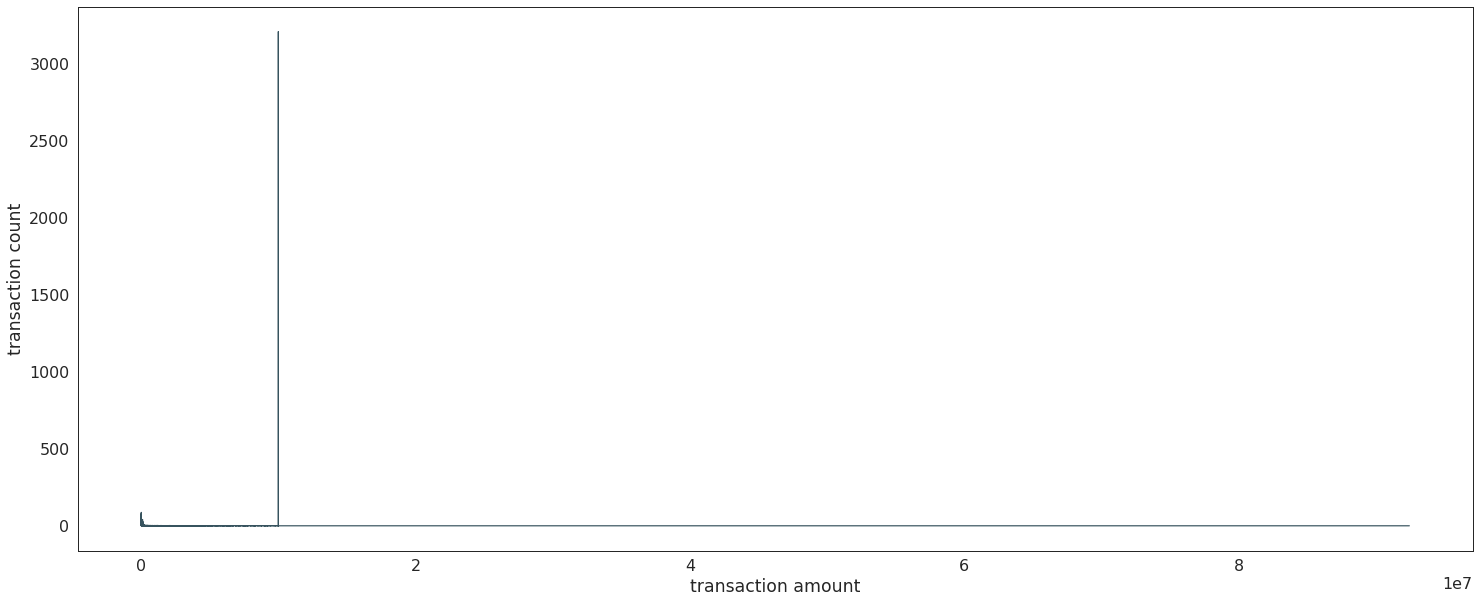

In [29]:
plt.figure(figsize=(25, 10))
sns.lineplot(x="amount", y="step", 
             data=df.groupby("amount").count().reset_index(), palette="BuGn_r")
plt.xlabel("transaction amount")
plt.ylabel("transaction count")
plt.show()